In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import random

# Loading data

In [2]:
df_pro_contacts_adults = pd.read_csv("pro_contacts_adults.csv", index_col=0)
df_pro_contacts_children = pd.read_csv("pro_contacts_children.csv", index_col=0)
df_households = pd.read_csv("households.csv", index_col=0)


#infos
print(df_households.sum())
#df_households.describe()
#df_pro_contacts_children.describe()
#df_pro_contacts_adults.describe()




nb_children                                                 3085
nb_adults                                                   6960
type           two_parent_familytwo_parent_familytwo_parent_f...
size                                                       10045
dtype: object


# Initializing the graph

We start by defining the classes whose instances will be the nodes of our graph

In [3]:
import math
class Person():
    def __init__(self, person_id, state, age):
        self.person_id = person_id
        self.age = age
        self.state = state
        self.working = True #will change during confinement or sick leave
        
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)
    
    def __str__(self):
        s = "Person #{}".format(self.person_id)
        return(s)
    
    def __repr__(self):
        s = "Person #{}".format(self.person_id)
        return(s)


class Adult(Person):
    def __init__(self, person_id, state, job_cat, pro_contacts, company_id):
        super().__init__(person_id, state, "adult")
        self.job_cat = job_cat
        if (type(self.job_cat) == float and math.isnan(self.job_cat)):
            self.job_cat = "nan"
        self.pro_contacts = pro_contacts
        self.company_id = company_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

class Child(Person):
    def __init__(self, person_id, state, school_contacts, school_id):
        super().__init__(person_id, state, "child")
        self.job_cat = job_cat
        self.school_contacts = school_contacts
        self.school_id = school_id
        
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

We create an empty graph into which we add nodes from the pro_contacts dataframes.

In [4]:
G = nx.Graph()
people = [] # we'll store Person objects here too in order to be able to access them quickly with person_id


for i, row in df_pro_contacts_adults.iterrows(): #We add adults to the nodes
    person_id = row.adult_id
    state = "S"
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    adult_node = Adult(person_id, state, job_cat, pro_contacts, company_id)
    G.add_node(adult_node)
    people.append(adult_node)
    
for i, row in df_pro_contacts_children.iterrows(): #We add childrens to the nodes
    person_id = row.child_id
    state = "S"
    school_contacts = row.school_contacts
    school_id = row.school_id
    
    child_node = Child(person_id, state, school_contacts, school_id)
    G.add_node(child_node)
    people.append(child_node)

    #print(G.nodes())
    


# Creating cliques for households

In [5]:
n_households = max(max(df_pro_contacts_children.index), max(df_pro_contacts_adults.index))
for id_household in range(n_households):
    df_household_adults = df_pro_contacts_adults.loc[df_pro_contacts_adults.index == id_household]
    household_adults = df_household_adults.adult_id
    
    df_household_children = df_pro_contacts_children.loc[df_pro_contacts_children.index == id_household]
    household_children = df_household_children.child_id
    
    household_people_ids = list(household_children) + list(household_adults)
    for edge in combinations(household_people_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "household"
        G[a][b]["id"] = id_household
        



In [6]:
if (False):
    #pos = nx.spring_layout(G, iterations=20)
    nx.draw_networkx_nodes(G,pos,node_size=30 ,alpha =0.3)
    nx.draw_networkx_edges(G, pos)
    

# Creating cliques for companies

In [7]:
n_companies = int(max(df_pro_contacts_adults.company_id))
for company_id in range(n_companies):
    df_company = df_pro_contacts_adults.loc[df_pro_contacts_adults.company_id == company_id]
    company_employees_ids = list(df_company.adult_id)
    
    for edge in combinations(company_employees_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "company"
        G[a][b]["id"] = company_id

In [8]:
"""#calcule la position des nodes pour afficher le graph 
# /!\ très lent /!\
pos = nx.spring_layout(G, iterations=1)
edge_color = []
for edge in G.edges():
    #print(edge)
    edge = G[edge[0]][edge[1]]
    if edge["type"] == "company":
        edge_color.append("b")
    if edge["type"] == "household":
        edge_color.append("r")
    

nx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)
nx.draw_networkx_edges(G, pos,edge_color = edge_color)"""



'#calcule la position des nodes pour afficher le graph \n# /!\\ très lent /!pos = nx.spring_layout(G, iterations=1)\nedge_color = []\nfor edge in G.edges():\n    #print(edge)\n    edge = G[edge[0]][edge[1]]\n    if edge["type"] == "company":\n        edge_color.append("b")\n    if edge["type"] == "household":\n        edge_color.append("r")\n    \n\nnx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)\nnx.draw_networkx_edges(G, pos,edge_color = edge_color)'

# Adding links for pro life outside the company

In [9]:
for i, row in df_pro_contacts_adults.iterrows():
    adult_id = row.adult_id
    job_cat = row.job_cat
    n_pro_contacts = row.pro_contacts
    company_id = row.company_id  

    pro_contacts = random.choices(list(df_pro_contacts_adults.loc[df_pro_contacts_adults.adult_id != adult_id].adult_id), k=n_pro_contacts)
    #print(len(pro_contacts))
    for pro_contact_id in pro_contacts:
        G.add_edge(people[adult_id], people[pro_contact_id])
        G[people[adult_id]][people[pro_contact_id]]["type"] = "pro_contact"
        
for i, row in df_pro_contacts_children.iterrows():
    child_id = row.child_id
    n_school_contacts = row.school_contacts
    school_id = row.school_id
    
    school_pupils_ids = list(df_pro_contacts_children.loc[(df_pro_contacts_children.school_id == school_id) & (df_pro_contacts_children.child_id != child_id)].child_id)
    school_contacts_ids = random.choices(school_pupils_ids, k=n_school_contacts)
    #print(len(school_contacts_ids))
    
    for school_contact_id in school_contacts_ids :
        G.add_edge(people[child_id], people[school_contact_id])
        G[people[child_id]][people[school_contact_id]]["type"] = "school"

# Exporting the graph for visualization with Gephi

In [10]:
nx.write_gexf(G, "test.gexf")

# Modeling Coronavirus behaviour without any action taken

### illness duration
https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext#seccestitle150 in this paper we see that in average an infected personne has symptomes for 20 days (worst and best being 8 days and 37 days). This is more or less independent of the fact that the individual recovers or die after thos 20 days. I will thus use this to calculate the half-life of the infected state. 

### infection probability
the R0 is given at 2.5. we calculate the probability of infecting a neighbor node using this and the mean duration of the infected state of 20 days. 




In [11]:
import numpy as np
# infected state duration and evolution
mean_sickness_duration = 20
half_life = mean_sickness_duration * np.log(2) 
daily_proba_change = 1 - (1/2)**(1/half_life) 

child_mortality = 0.002
adult_mortality = 0.02

child_recovery = 1- child_mortality
adult_recovery = 1- adult_mortality

mean_degree = len(G.edges) * 2 /len(G.nodes)
print(mean_degree)

#infection probability for each link daily
R0 = 2.5 
daily_infection_proba = R0 / mean_sickness_duration


275.318068690891


#  Economic impact

We gauge economic impact by counting the number of people who cannot work daily 
pondered by the importance of their activity sector. We choose to follow this communiqué to get the sectors importance https://moodle.imt-atlantique.fr/mod/url/view.php?id=18312

We choose the crutial categories like Health and food whitch cannot be in lockdown.
For the others we use the estimate of how much remote work is possible.

All classes have a PIB weight value. It represents how much its function contribute to the PIB. 


In [12]:
#df_pro_contacts_adults.groupby("job_cat").mean()


In [13]:

class Job_category():
    
    def __init__(self,job_cat, category,remote_work_possibility, remote_work, PIB_weight):
        self.job_cat = job_cat # name in the dataframe
        self.category =category #equivalent in the communiqué
        self.remote_work_possibility = remote_work_possibility #false for health and agriculture
        self.remote_work = remote_work #percentage of remote work efficiency 
        self.PIB_weight = PIB_weight #found in the communiqué
        self.categ_pop = 1 #will be changed to the exact population in this categorie



        
job_info = dict()
job_info['Administration_schools'] = Job_category(job_cat = 'Administration_schools',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.14,
                                                  PIB_weight = 0.22)

job_info['Agriculture_fishing'] = Job_category(job_cat = 'Agriculture_fishing',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.04)

job_info['Construction'] = Job_category(job_cat = 'Construction',
                                                  category = 'Construction',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.89,
                                                  PIB_weight = 0.06)

job_info['Health'] = Job_category(job_cat = 'Health',
                                                  category = 'Health',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.5,
                                                  PIB_weight = 0.22)

job_info['Hotel_Restaurant'] = Job_category(job_cat = 'Hotel_Restaurant',
                                                  category = 'Services marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.56)

job_info['Indus_food'] = Job_category(job_cat = 'Indus_food',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.80,
                                                  PIB_weight = 0.04)
job_info['Indus_other'] = Job_category(job_cat = 'Indus_other',
                                                  category = 'Industrie hors agro-alimentaire',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.52,
                                                  PIB_weight = 0.12)

job_info['Services_other'] = Job_category(job_cat = 'Services_other',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.14,
                                                  PIB_weight = 0.22)

job_info['Shops_market_food'] = Job_category(job_cat = 'Shops_market_food',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.04)
job_info['Shops_other'] = Job_category(job_cat = 'Shops_other',
                                                  category = 'Services marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.36,
                                                  PIB_weight = 0.56)
job_info['Transportation'] = Job_category(job_cat = 'Transportation',
                                                  category = 'Transportation',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.36,
                                                  PIB_weight = 0.56)
job_info['nan'] = Job_category(job_cat = 'nan',
                                                  category = 'None',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 ,
                                                  PIB_weight = 0.0)

# the joc_cat given in the population data and the job categories from the communiqué
#are not the same so I mapped one to the other and I found the population of each category in the graph
#this will allow us to get the effect of each person working on the PIB
# personnal PIB impact = PIB_weight of the category / population of the category * working_efficiency

categ_pop = dict()  
for node in G.nodes:
    if type(node) == Adult:
        category = job_info[node.job_cat].category
        if category not in categ_pop:
            categ_pop[category] = 0
        categ_pop[category]+=1


for job in job_info:
    job_info[job].categ_pop = categ_pop[job_info[job].category]
    

        


In [18]:

import random 


class Basic_SIR_Model():
    """Model SIR with permanent recovery. 
        Nobody changes their behavior in front of the virus
        No sick leave, no confinement
    """
    def __init__(self,G):
        import random
        self.G = G # This model's graph
        
        self.relation_type = ["household", "company", "school", "pro_contact"]
        
        self.infection_states =["S" #sane
                ,"I" #infected
                ,"D" #dead
                ,"R"] #recovered
        
        #infetion probabilities are for each interactions everydays 
        #death and recovery proba are for one day
        mean_degree = len(self.G.edges) * 2 /len(self.G.nodes)
        daily_link_infection_proba = daily_infection_proba / mean_degree # this gives R0 = 2.5
        
        self.infection_probas=dict() #probability of infection dependeing on the type of the interaction
        self.infection_probas['company']= daily_link_infection_proba
        self.infection_probas['pro_contact']= daily_link_infection_proba * 0.9
        self.infection_probas['school']= daily_link_infection_proba * 1.4
        self.infection_probas["household"]= daily_link_infection_proba * 1.5 
        # because you spend more time with your family than with your coworkers
        
        self.death_proba=dict() #daily proba of death if infected
        self.death_proba["adult"]= daily_proba_change * adult_mortality
        self.death_proba["child"]= daily_proba_change * child_mortality

        self.recovery_proba=dict() #daily proba of recovery if infected
        self.recovery_proba["adult"]= daily_proba_change * adult_recovery 
        self.recovery_proba["child"]= daily_proba_change * child_recovery 
        
        self.population = len(self.G.nodes)
        self.adult_pop = len ([nd for nd in list(self.G.nodes) if (type(nd)==Adult)])
        
        self.day = 0
        self.hist = dict() # values day by day  will be stored here

    def initialize_patients_zero(self, number_of_first_cases = 1):
        for node in list(self.G.nodes()): # everybody is sane at the begining 
            node.state = "S"
            if type(node) == Adult:
                node.working = True #at beginning all adults work
        print('first infected are:') 
        for random_pick in random.sample(list(self.G.nodes()), number_of_first_cases): 
            print(random_pick)
            random_pick.state = "I"
        
 
        
            
        

    def interaction(self,interaction_type): # return true if there is an infection
        return ( random.random()<=self.infection_probas[interaction_type])

    def sickness_evolution(self,age): # return state of the infected at the end of the day
        r = random.random()
        if r <= self.death_proba[age]:
            return "D"
        if r<= self.recovery_proba[age]:
            return "R"
        else:
            return "I"

    def one_normal_day_passes(self): #update all the graph everybody meets all its neighbors
        #print("today everybody went to work as usual.")
        self.changing_state = dict() # store the nodes that change state before updating them all at once
        for state in self.infection_states:
            self.changing_state[state]= []

        for node in list(self.G.nodes()):
            self.meet_all_permited_people(node,self.relation_type)#where infection happens
            
            #we check if the condition of the sick change (death recovery or no change)
            if node.state == "I":     
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    self.changing_state[new_state].append(node)                    

        for state in self.infection_states: #update all the nodes states at once after all the interactions
            for node in self.changing_state[state]:
                node.state = state
                #for now sick people work because this scenario is low-key distopian
                if(state == "D" and type(node) == Adult): 
                    node.working = False #dead people don't work :'(
    
    def meet_all_permited_people(self,node, authorised_relation):
        if node.state == "I": 
            for neig in self.G[node]: 
                    if neig.state == "S":
                        t = self.G[node][neig]['type']
                        if t in authorised_relation:#will not meet people from wrong relation group
                            if self.interaction(t):
                                self.changing_state["I"].append(neig)#infect neighbor :'(
                
    
    def store_economic_data(self):
        if ("Adults not working" not in self.hist):
            self.hist["Adults not working"] = ([],"economic")
        not_working_adults = [nd for nd in list(self.G.nodes) if (type(nd)==Adult and nd.working==False)]
        lazy = len(not_working_adults)/self.adult_pop
        self.hist["Adults not working"][0].append([lazy,self.day])
        
        #daily PIB
        if("Daily PIB" not in self.hist):
            self.hist["Daily PIB"] = ([],"economic")
        if("Daily PIB loss" not in self.hist):
            self.hist["Daily PIB loss"] = ([],"economic") 
        PIB = 0
        for adult in [nd for nd in list(self.G.nodes) if (type(nd)==Adult) ]:
            job_cat = job_info[adult.job_cat]
            
            if adult.working:
                work_efficiency = 1
            else : 
                work_efficiency = 0
                
            daily_PIB_impact = job_cat.PIB_weight / job_cat.categ_pop * work_efficiency
            PIB += daily_PIB_impact / 1.785 #not really nice way to do it but I don't have time to do it properly
        
        self.hist["Daily PIB"][0].append([PIB , self.day])
        self.hist["Daily PIB loss"][0].append([1 - PIB , self.day])
            
                                                          
    
        
    #called to save population data in self.hist    
    def store_infection_state_pop(self): 
        for state in self.infection_states:
            if (state not in self.hist):
                self.hist[state] = ([],"health")
            
            self.hist[state][0].append([len([nd for nd in list(self.G.nodes) if nd.state == state ]),
                                     self.day])    
               
    def plot_hist(self): #plot everything stored
        print("After 365 days")
        print("death     : ",self.hist["D"][0][-1][0])
        print("PIB lost  : ",sum([x[0] for x in m.hist["Daily PIB loss"][0]])/m.day)
        from matplotlib import pyplot as plt
        plt.subplot(2,1,1)
        for val in self.hist:
            if val != "S" and self.hist[val][1]== "health":
                X  = [p[1] for p in self.hist[val][0]]
                Y  = [p[0] for p in self.hist[val][0]]
                plt.plot(X,Y,label = val)
        plt.xlabel("days since first case")
        plt.ylabel("population")
        plt.legend(loc="upper left")
        #plt.yscale('log')
        plt.subplot(2,1,2)
        for val in self.hist:
            if  self.hist[val][1]== "economic" and val!= "Daily PIB":
                X  = [p[1] for p in self.hist[val][0]]
                Y  = [p[0] for p in self.hist[val][0]]
                plt.plot(X,Y,label = val)
        plt.xlabel("days since first case")
        plt.ylabel("percentage")
        plt.legend(loc="upper left")
        #plt.yscale('log')
        
        plt.show()
            
    #launch this to simulate a basic scenario for one year
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_normal_day_passes() #transmition happens
            self.store_infection_state_pop() #we save data for the graph
            self.store_economic_data()
            self.day +=1 #nex day starts
        self.plot_hist()
            


first infected are:
Person #5879
Person #6752
Person #1817
Person #7213
Person #3618
After 365 days
death     :  127
PIB lost  :  0.01837795029388496


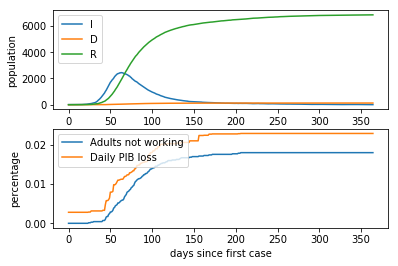

In [19]:
#We put 5 infected in a untouched country which take no counter-mesure for a year
m = Basic_SIR_Model(G)
m.basic_scenario()



## Basic counter-mesure: Killing the sick preventivelly

first I try something very basic and cruel: The state kills every infected it can find. 
I suppose that the state take action once 200 people are infected. (time to discover there existence)
I suppose they can test everybody but with a technology that is not very reliable 0.3 chance to discover the virus and no false positive.
The results are not great at all, the virus still spreads but is now indirectly way worst

first infected are:
Person #6073
Person #3591
Person #8348
Person #6272
Person #1969
57  killed during search
70  killed during search
65  killed during search
56  killed during search
70  killed during search
61  killed during search
59  killed during search
66  killed during search
67  killed during search
74  killed during search
50  killed during search
59  killed during search
75  killed during search
70  killed during search
62  killed during search
58  killed during search
66  killed during search
78  killed during search
68  killed during search
66  killed during search
59  killed during search
65  killed during search
56  killed during search
74  killed during search
70  killed during search
61  killed during search
74  killed during search
72  killed during search
59  killed during search
After 365 days
death     :  1925
PIB lost  :  0.2653331407550458


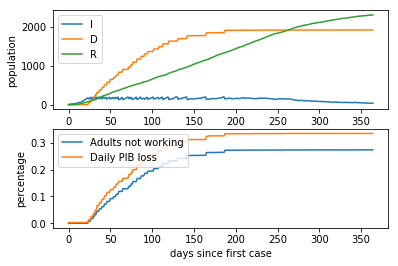

In [20]:
# we try to kill every infected once we discover them
class North_Korea(Basic_SIR_Model):
    def __init__(self,G):
        super().__init__(G)
        self.execution_proba = 0.3 #chance to be caught and executed if you are sick during a search
    
    def search(self): 
        nb_killed = 0
        for node in list(self.G.nodes()):
            if(node.state == "I"): 
                r = random.random()
                if r < self.execution_proba: #we try to kill the infected quickly
                    node.state = "D"
                    node.working = False
                    nb_killed +=1
        print(nb_killed," killed during search")
    
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_normal_day_passes()
            nb_infected = len([nd for nd in list(self.G.nodes) if nd.state == "I" ])   
            if nb_infected > 200 :
                m.search()
            self.store_infection_state_pop()
            self.store_economic_data()
            self.day+=1
        self.plot_hist()



m = North_Korea(G)
m.basic_scenario()
        
        

# Basic counter-mesure: sick leave

People are allowed to take sick leave if they have the symptoms. Everyday if you have the symptoms you have a chance to notice them and to stop working until death or recovery. During that time, the node will only be in contact with its houshold.

first infected are:
Person #2837
Person #10004
Person #6975
Person #9009
Person #5967
After 365 days
death     :  89
PIB lost  :  0.03383353287353479


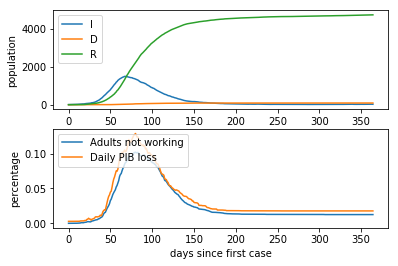

In [21]:
class Sick_leave_model(Basic_SIR_Model):
    def __init__(self,G):
        super().__init__(G)
        self.sickness_awarness = dict()
        self.sickness_awarness["adult"]= 0.05 #daily probability of noticing you are infected
        self.sickness_awarness["child"]= 0.01 #daily probability of noticing you are infected
        
    def one_day_passes_sick_leave(self): #same but sick leave exists now
        
        self.changing_state = dict() # store the nodes that change state before updating them all at once
        for state in self.infection_states:
            self.changing_state[state]= []

        for node in list(self.G.nodes()):
            if node.state == "I":  #for every infected people
                
                if (not node.working): #people on sick leave Adult and childrens
                    self.meet_all_permited_people(node, ["household"] )#no contact with co workers
                
                else: #working people and childrens going to school
                    self.meet_all_permited_people(node, self.relation_type)        
                #we check if the condition of the sick change (death recovery or no change)
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    self.changing_state[new_state].append(node)
                    
                #Sick adults may take a sick leave if they notice the syptomes
                if (type(node) == Adult and node.working): #people take sick leave
                    node.working = (random.random() >= self.sickness_awarness[node.age] )

                    
        for state in self.infection_states: #update all the nodes states at once after all the interactions
            for node in self.changing_state[state]:
                node.state = state
                #for now sick people work because this scenario is low-key distopian
                if(state == "D" and type(node) == Adult): 
                    node.working = False #dead people don't work :'(
                
                if(state == "R" and type(node) == Adult): #sick leave ends
                    node.working = True
                
    def sick_leave_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_day_passes_sick_leave()
            self.store_infection_state_pop()
            self.store_economic_data()
            self.day+=1
        self.plot_hist()
 
    
m = Sick_leave_model(G)
m.sick_leave_scenario()
        

# Confinement and school closure

wont work :
['Administration_schools', 'Construction', 'Hotel_Restaurant', 'Indus_other', 'Services_other', 'Shops_other', 'nan']
first infected are:
Person #2494
Person #4343
Person #9971
Person #326
Person #244
Person #2271
Person #8071
Person #4510
Person #30
Person #2277
After 365 days
death     :  96
PIB lost  :  0.12847042207046344


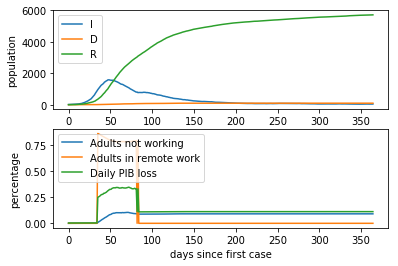

In [33]:
class Confinement_model(Sick_leave_model):
    def __init__(self, G):
        super().__init__(G)
        
        self.school_closed = False
        self.remote_work= dict() #positive for job category who will have to work from home
        for job in job_info:
            self.remote_work[job] = False
    
    #Override the original to take into account remote work
    def store_economic_data(self):
        if ("Adults not working" not in self.hist):
            self.hist["Adults not working"] = ([],"economic")
        not_working_adults = [nd for nd in list(self.G.nodes) if (type(nd)==Adult and nd.working==False)]
        lazy = len(not_working_adults)/self.adult_pop
        self.hist["Adults not working"][0].append([lazy,self.day])
        
        if ("Adults in remote work" not in self.hist):
            self.hist["Adults in remote work"] = ([],"economic")
        remote_adult = [nd for nd in list(self.G.nodes) 
                        if (type(nd)==Adult and nd.working==True and self.remote_work[nd.job_cat])]
        remote_percent = len(remote_adult)/self.adult_pop
        self.hist["Adults in remote work"][0].append([remote_percent,self.day])
        
        #daily PIB
        if("Daily PIB" not in self.hist):
            self.hist["Daily PIB"] = ([],"economic")
        if("Daily PIB loss" not in self.hist):
            self.hist["Daily PIB loss"] = ([],"economic") 
        PIB = 0
        for adult in [nd for nd in list(self.G.nodes) if (type(nd)==Adult) ]:
            job_cat = job_info[adult.job_cat]
            # we calculate work efficiency
            if adult.working:
                if adult in remote_adult:
                    work_efficiency = job_info[adult.job_cat].remote_work
                else:
                    work_efficiency = 1
            else : 
                work_efficiency = 0
                
            daily_PIB_impact = job_cat.PIB_weight / job_cat.categ_pop * work_efficiency
            PIB += daily_PIB_impact / 1.785 #not really nice way to do it but I don't have time to do it properly
        
        self.hist["Daily PIB"][0].append([PIB , self.day])
        self.hist["Daily PIB loss"][0].append([1 - PIB , self.day])
            
                                                 
    
    def one_day_passes_confinement(self,job_cat_list,school_closed): #same but sick leave exists now
        #set the job categories who will work from home
        for job in self.remote_work:
            self.remote_work[job] = False
        
        for job in job_cat_list:
            self.remote_work[job] = True
        
        self.changing_state = dict() # store the nodes that change state before updating them all at once
        for state in self.infection_states:
            self.changing_state[state]= []

        for node in list(self.G.nodes()):
            
            if type(node) == Child: 
                if school_closed:
                    self.meet_all_permited_people(node,["household"])
                else:  
                    if node.working:
                        self.meet_all_permited_people(node, self.relation_type) 
            
            if type(node) == Adult:
                if node.job_cat in job_cat_list and node.working:
                    self.meet_all_permited_people(node, self.relation_type) 
                else: 
                    self.meet_all_permited_people(node,["household"])
                    
                
            #we check if the condition of the sick change (death recovery or no change)
            if node.state == "I":  #for every infected people                
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    self.changing_state[new_state].append(node)

                #Sick adults may take a sick leave if they notice the syptomes
                if (type(node) == Adult and node.working): #people take sick leave
                    node.working = (random.random() >= self.sickness_awarness[node.age] )

        #update all the nodes states at once after all the interact            
        for state in self.infection_states: 
            for node in self.changing_state[state]:
                node.state = state
                #for now sick people work because this scenario is low-key distopian
                if(state == "D" and type(node) == Adult): 
                    node.working = False #dead people don't work :'(

                if(state == "R" and type(node) == Adult): #sick leave ends
                    node.working = True

    
    def confinement_scenario(self): 
        job_cat_list = [job_cat for job_cat in job_info.keys() if (job_info[job_cat].remote_work_possibility)]
        print("wont work :")
        print(job_cat_list)
        self.initialize_patients_zero(number_of_first_cases=10)
        for i in range(365):
            nb_infected = len([nd for nd in list(self.G.nodes) if nd.state == "I" ])   
            if nb_infected > 800 :
                self.one_day_passes_confinement(job_cat_list = job_cat_list,school_closed = True)
            else:
                for job in job_info:
                    self.remote_work[job] = False
                self.one_normal_day_passes()

            
            self.store_infection_state_pop()
            self.store_economic_data()
            self.day+=1
        self.plot_hist()


m = Confinement_model(G)
m.confinement_scenario()

    

In [24]:
m.hist


{'S': ([[10040, 0],
   [10040, 1],
   [10040, 2],
   [10039, 3],
   [10036, 4],
   [10034, 5],
   [10032, 6],
   [10030, 7],
   [10028, 8],
   [10025, 9],
   [10024, 10],
   [10021, 11],
   [10021, 12],
   [10020, 13],
   [10019, 14],
   [10014, 15],
   [10012, 16],
   [10009, 17],
   [10006, 18],
   [10000, 19],
   [9994, 20],
   [9984, 21],
   [9978, 22],
   [9970, 23],
   [9968, 24],
   [9959, 25],
   [9950, 26],
   [9936, 27],
   [9925, 28],
   [9912, 29],
   [9894, 30],
   [9879, 31],
   [9862, 32],
   [9848, 33],
   [9827, 34],
   [9803, 35],
   [9781, 36],
   [9762, 37],
   [9741, 38],
   [9710, 39],
   [9669, 40],
   [9631, 41],
   [9588, 42],
   [9552, 43],
   [9497, 44],
   [9433, 45],
   [9385, 46],
   [9319, 47],
   [9260, 48],
   [9185, 49],
   [9113, 50],
   [9021, 51],
   [8947, 52],
   [8846, 53],
   [8772, 54],
   [8702, 55],
   [8626, 56],
   [8564, 57],
   [8503, 58],
   [8434, 59],
   [8371, 60],
   [8304, 61],
   [8236, 62],
   [8171, 63],
   [8115, 64],
   [8046, 